# Introduction

Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

# Objective

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

## Code

In [ ]:
"""Imports"""
import cv2
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from midi2audio import FluidSynth
from miditok import REMI, TokenizerConfig
from miditok.data_augmentation import augment_dataset
from miditok.utils import split_files_for_training
from pathlib import Path
from random import sample, seed as random_seed
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchmetrics.classification import MulticlassConfusionMatrix
from torchvision import transforms
from torchvision.io import decode_image

In [2]:
"""Set seeds and device"""
random_seed(73)
np.random.seed(73)
torch.manual_seed(73)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(73)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Data Collection: Data is collected and provided to you.

In [23]:
"""Include data EDA from Anitra's branch here"""

"Include data EDA from Anitra's branch here"

### Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.

In [ ]:
"""Train a tokenizer on each composer, split the data by number of tokens and augment the data"""
config = TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True, one_token_stream_for_programs=False)
tokenizer = REMI(config)

DATA_PATH = Path(Path.cwd().parent, "Data")
RETAIN = 100

for composer in ["Bach", "Beethoven", "Chopin", "Mozart"]:
	print(f"{composer}:")
	midi_path = list(Path(DATA_PATH, "Raw").glob(f"{composer}/*.mid"))
	tokenizer.train(vocab_size=500, files_paths=midi_path)
	subset_chunks_dir = Path(DATA_PATH, "Augmented", composer)
	
	split_files_for_training(
        files_paths=midi_path,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
		min_seq_len=1024
    )

	augment_dataset(
		subset_chunks_dir,
		pitch_offsets=[-6, 6],
		velocity_offsets=[-4, 4],
		duration_offsets=[-0.2, 0.2],
		save_data_aug_report=False,
	)

	# use RETAIN as upper bound of song count and remove excess at random to balance composer data
	all_files = list(Path(subset_chunks_dir).glob("*.mid"))
	composer_sample = sample(all_files, len(all_files) - RETAIN)
	for file_name in composer_sample:
		file_name.unlink()

Bach:
Performing data augmentation: 100%|██████████| 108/108 [00:24<00:00, 500.35it/s]
Beethoven:
Performing data augmentation: 100%|██████████| 51/51 [00:27<00:00, 460.36it/s]
Chopin:
Performing data augmentation: 100%|██████████| 15/15 [01:38<00:00, 119.72it/s]
Mozart:
Performing data augmentation: 100%|██████████| 21/21 [00:04<00:00, 527.91it/s]


### Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

Notes, chords, and tempos were all extracted as part of the tokenization process for splitting and augmenting.  However, we plan to use image data for this project so we will include our process for extracting the relavant data to build the image feature here.

In [ ]:
"""Convert midi file to spectrogram images and create mapping csv for classification"""
def scale_minmax(data, minimum, maximum):
    data_min, data_max = data.min(), data.max()
    std = (data - data_min) / (data_max - data_min)
    return std * (maximum - minimum) + minimum

def save_spectrogram_image(data, sampling_rate, out, hop_length, n_mels):
    mels = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # avoid log(0) error

    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0)
    img = 255-img

    cv2.imwrite(out, img)
    
def get_composer_class(composer):
	if "Bach" in composer:
		return 0
	elif "Beethoven" in composer:
		return 1
	elif "Chopin" in composer:
		return 2
	elif "Mozart" in composer:
		return 3
	else:
		raise NameError

fluidsynth = FluidSynth()
DATA_PATH = Path(Path.cwd().parent, "Data")
spectrogram_midi_path = list(Path(DATA_PATH, "Augmented").glob(f"**/*.mid"))
spectrogram_path = Path(DATA_PATH, "Spectrogram")
labels = pd.DataFrame(columns=["filename", "class"])

for midi in spectrogram_midi_path:
	composer, filename = midi.parts[-2:]
	audio_filename = Path(spectrogram_path, filename.replace(".mid", ".flac"))
	output_filename = Path(spectrogram_path, filename.replace(".mid", ".png"))
	fluidsynth.midi_to_audio(midi, audio_filename)

	audio, fs = librosa.load(audio_filename, sr=None)
     
	time_steps = 384 # number of time-steps
	hop_length = 512 # Samples per time-step
	n_mels = 128 # Height of image
    
	save_spectrogram_image(audio[:time_steps*hop_length], sampling_rate=fs, out=output_filename, hop_length=hop_length, n_mels=n_mels)
	audio_filename.unlink()
	filename = output_filename.parts[-1]
	try:
		classification = get_composer_class(composer)
	except NameError:
		print(output_filename)
		
	labels.loc[len(labels)] = [filename, classification]

labels.to_csv(Path(DATA_PATH, "Spectrogram", "all.csv"))

FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.


In [3]:
"""Custom classes for loading data through dataloader as adapted from https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html"""
class SpectrogramDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = Path(self.img_dir, self.img_labels.iloc[idx, 1])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
"""Load data using custom class defined above and split into train/validate/test datasets"""
DATA_PATH = Path(Path.cwd().parent, "Data")
data_transformers=transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor()])

leaf_dataset = SpectrogramDataset(annotations_file=Path(DATA_PATH, "Spectrogram", "all.csv"), img_dir=Path(DATA_PATH, "Spectrogram"), transform=data_transformers)
train_dataset, valid_dataset, test_dataset = random_split(leaf_dataset, [0.6, 0.2, 0.2])

train_dataset

In [6]:
"""Convert those datasets into batch loaders"""
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

train_loader

### Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.

In [ ]:
"""Combined CNN-LSTM architecture as adapted from https://www.mathworks.com/help/deeplearning/ug/sequence-classification-using-cnn-lstm-network.html"""
class ComposerClassifier(nn.Module):
    def __init__(self, input_size, filter_size, num_filters, num_hidden_units, num_classes):
        super(ComposerClassifier, self).__init__()
        self.convolve = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),

            nn.Conv2d(in_channels=num_filters, out_channels=2*num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),

            nn.Conv2d(in_channels=2*num_filters, out_channels=2*num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),

            nn.Flatten(),
        )
        self.lstm = nn.LSTM(input_size=3072, hidden_size=256, batch_first=True)
        self.linear = nn.Linear(num_hidden_units, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.convolve(x)
        x, (h, c) = self.lstm(x)
        x = self.linear(x)
        return self.softmax(x)

### Model Training: Train the deep learning model using the pre-processed and feature-extracted data.

In [ ]:
"""Define training loop for CNN-LSTM model"""
def train(model, training, validation, lr=0.001):
	criterion = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	
	train_losses = []
	for inputs, labels in training:
		model.train()
		optimizer.zero_grad()
		output = model(inputs)
		loss = criterion(output, labels)
		loss.backward()
		optimizer.step()
		train_losses.append(loss.item())
		break

	validation_losses = []
	with torch.no_grad():
		for v_inputs, v_labels in validation:
			model.eval()
			v_output = model(v_inputs)
			validation_loss = criterion(v_output, v_labels)	
			validation_losses.append(validation_loss.item())
			break
	return train_losses, validation_losses

# Train CNN-LSTM model
epochs = 300
model = ComposerClassifier(input_size=1, filter_size=3, num_filters=64, num_hidden_units=256, num_classes=4)

total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
	epoch_train_loss, epoch_validation_loss = train(model, train_loader, valid_loader)
	total_train_losses.extend(epoch_train_loss)
	total_validation_losses.extend(epoch_validation_loss)
	if (epoch + 1) % 10 == 0:
		print(f"Epoch {epoch + 1}, train loss: {epoch_train_loss[-1]:.4f}, validation loss: {epoch_validation_loss[-1]:.4f}")

Epoch 10, train loss: 1.2554, validation loss: 1.3005
Epoch 20, train loss: 0.9682, validation loss: 1.3753
Epoch 30, train loss: 0.8815, validation loss: 1.4176
Epoch 40, train loss: 0.8585, validation loss: 1.1937
Epoch 50, train loss: 0.8351, validation loss: 1.0254
Epoch 60, train loss: 0.7743, validation loss: 1.0402
Epoch 70, train loss: 0.7620, validation loss: 0.9738
Epoch 80, train loss: 0.7544, validation loss: 0.7573
Epoch 90, train loss: 0.7476, validation loss: 1.0185
Epoch 100, train loss: 0.7444, validation loss: 0.7440
Epoch 110, train loss: 0.7472, validation loss: 0.7799
Epoch 120, train loss: 0.7444, validation loss: 0.7444
Epoch 130, train loss: 0.7437, validation loss: 0.7598
Epoch 140, train loss: 0.7437, validation loss: 0.7596
Epoch 150, train loss: 0.7437, validation loss: 0.7507
Epoch 160, train loss: 0.7437, validation loss: 0.7507
Epoch 170, train loss: 0.7437, validation loss: 0.7458
Epoch 180, train loss: 0.7437, validation loss: 0.7472
Epoch 190, train lo

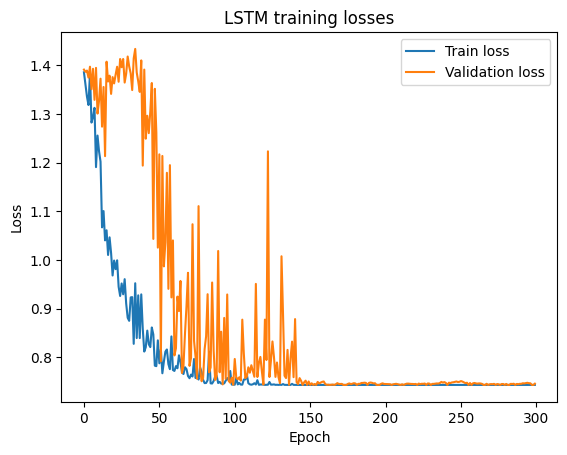

In [16]:
"""Plot training and Validation losses"""
plt.title("LSTM training losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses, label="Train loss")
plt.plot(total_validation_losses, label="Validation loss")
plt.legend()
plt.show()

### Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.

In [18]:
"""Create tensors to use in performance metric creation"""
prediction = torch.Tensor()
truth = torch.Tensor()

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        prediction = torch.cat([prediction, predicted], dim=0)
        truth = torch.cat([truth, labels], dim=0)
        
assert prediction.shape == truth.shape
print(prediction.shape)

torch.Size([80])


In [ ]:
"""Create performance metrics"""
accuracy = Accuracy(task="multiclass", num_classes=32)
precision = Precision(task="multiclass", average="macro", num_classes=32)
recall = Recall(task="multiclass", average="macro", num_classes=32)
f1_score = F1Score(task="multiclass", average="macro", num_classes=32)
confusion_matric = ConfusionMatrix(task="multiclass", num_classes=32)

calculated_accuracy = accuracy(truth, prediction)
calculated_precision = precision(truth, prediction)
calculated_recall = recall(truth, prediction)
calculated_f1_score = f1_score(truth, prediction)
calculated_confusion_matric = confusion_matric(truth, prediction)

print("Model Accuracy:", calculated_accuracy)
print("Model Precision:", calculated_precision)
print("Model Recall:", calculated_recall)
print("Model F1:", calculated_f1_score)

Model Accuracy: tensor(0.9750)
Model Precision: tensor(0.9755)
Model Recall: tensor(0.9749)
Model F1: tensor(0.9745)


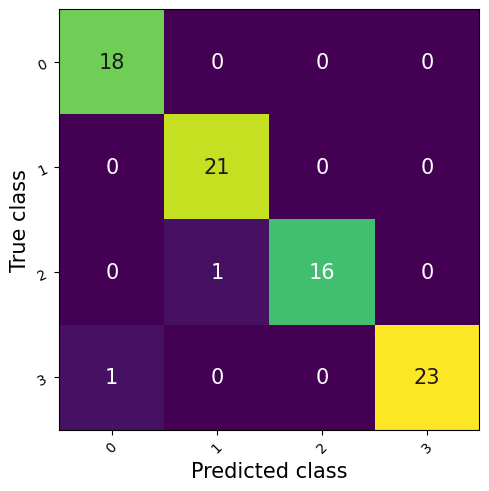

In [ ]:
"""Vizulaize confusion matrix"""
metric = MulticlassConfusionMatrix(num_classes=4)
metric.update(truth, prediction)
fig_, ax_ = metric.plot()

### Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.

In [24]:
"""Optimizations to come..."""

'Optimizations to come...'

## Findings